## Notebook to compare velocity dispersions at the terminal velocity to star formation tracers

### N McClure-Griffiths 23 May 2017

In [1]:
%matplotlib notebook
from numpy import *
from pylab import *
import os
from scipy import *
from scipy import stats
from matplotlib import rc
rc('mathtext', default='regular')


In [2]:
# Define some variables of general purpose use
dv = 20.0   # Velocity interval to use relative to the terminal velocity
bw1 = 0.05  # KDE Gaussian bandwidth for 2-d image
bw2 = 0.08  # KDE Gaussian bandwidth for 1-d plot


In [3]:
# Function to read the Miville-Deschenes CO clouds
def read_MD(fname='apjaa4dfdt1.dat'):
    csv = np.genfromtxt (fname,skip_header=45)
    l= csv[:,4]
    b = csv[:,6]
    v = csv[:,12]
    dvel= csv[:,13]
    return l,b,v,dvel

In [4]:
def read_HOPS(fname='/Users/naomi/Data/GASS/GalCen/version2/HOPS_NH3-11-DuchampCat.csv'):
    csv = np.genfromtxt (fname, delimiter=",",skip_header=1)
    l= csv[:,1]
    b = csv[:,3]
    v = csv[:,4]
    for i in range(len(l)):
        if l[i]>=180.: 
            l[i]=l[i]-360.
    return l,b,v
              

In [5]:
# Function to read the WISE HII regions
def read_WISE():
    csv = np.genfromtxt ('/Users/naomi/Data/GASS/GalCen/version2/wise_hii_V1.3.csv', delimiter=",",skip_header=1)
    l= csv[:,2]
    b = csv[:,3]
    v1 = csv[:,9]
    v2 = csv[:,10]
    wise_l=[]
    wise_b=[]
    wise_v=[]
    for i in range(len(l)):
        if l[i]>=180.: 
            l[i]=l[i]-360.
        if not np.isnan(v1[i]):
            wise_v.append(v1[i])
            wise_l.append(l[i])
            wise_b.append(b[i])
        elif not np.isnan(v2[i]):
            wise_v.append(v2[i])
            wise_l.append(l[i])
            wise_b.append(b[i])
    return array(wise_l),array(wise_b),array(wise_v)




In [6]:
# Generic function to read the terminal velocities from the data
def vterm(fname):
    csv = np.genfromtxt (fname,comments='%')
    l = csv[:,0]
    v = csv[:,1]
    for i in range(len(l)): 
        if l[i]>180.0: l[i]-=360.
    return np.array(l),np.array(v)

In [7]:
# Read in all of the data
lCO,bCO,vCO,dvel=read_MD()
wise_l,wise_b,wise_v=read_WISE()
lHOPS,bHOPS,vHOPS = read_HOPS()

In [109]:
l1,v1=vterm('term_vel_q1.dat')   # First quadrant values
l4,v4=vterm('term_vel_q4.dat')  # Fourth quadrant values

<IPython.core.display.Javascript object>


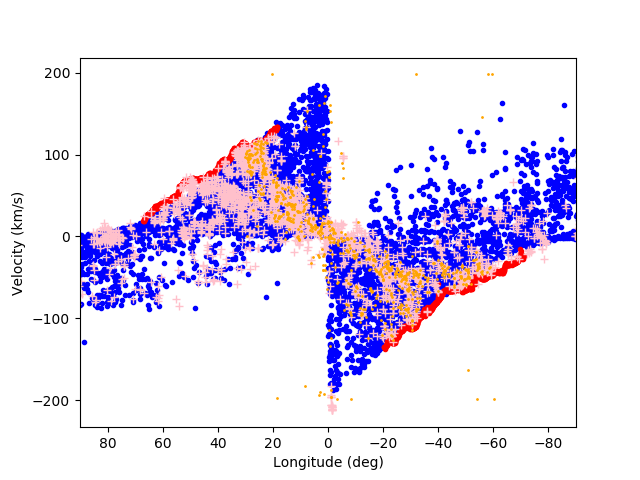

In [9]:
# Plot the CO clouds
figure()
plot(lCO,vCO,linestyle='None',marker='.',color='blue')
xlabel('Longitude (deg)')
ylabel('Velocity (km/s)')
xlim(90.,-90.)

# Plot the HI terminal velocities
plot(l1,v1,linestyle='None',marker='.',color='red')
plot(l4,v4,linestyle='None',marker='.',color='red')

# Plot the HII regions
plot(wise_l,wise_v,linestyle='None',marker='+',color='pink')
plot(lHOPS,vHOPS,linestyle='None',marker='.',color='orange',markersize=2)



<IPython.core.display.Javascript object>


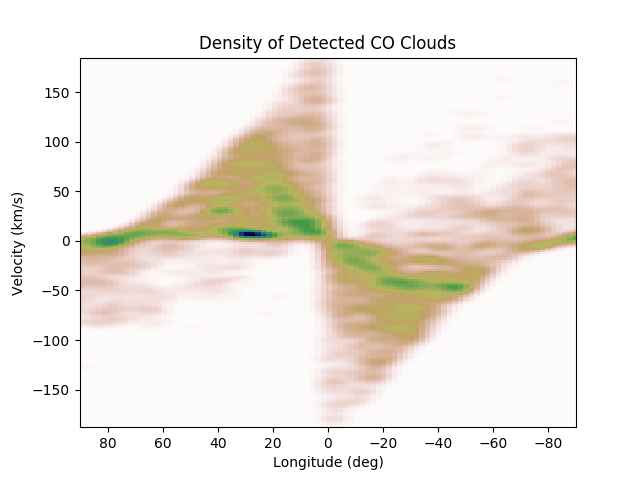

(90.0, -90.0)

In [10]:
# Make an image of the density of data points for the CO clouds

xmin = lCO.min()
xmax = lCO.max()
ymin = vCO.min()
ymax = vCO.max()

X, Y = np.mgrid[xmin:xmax:180j, ymin:ymax:180j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([lCO, vCO])

kernel = stats.gaussian_kde(values,bw_method=bw1)
Z = np.reshape(kernel(positions).T, X.shape)

figure()
imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax],aspect='auto')
#plot(l1,v1,linestyle='None',marker='.',color='black')
#plot(l4,v4,linestyle='None',marker='.',color='black')

xlabel('Longitude (deg)')
ylabel('Velocity (km/s)')
title("Density of Detected CO Clouds")
xlim(90.,-90.)


<IPython.core.display.Javascript object>


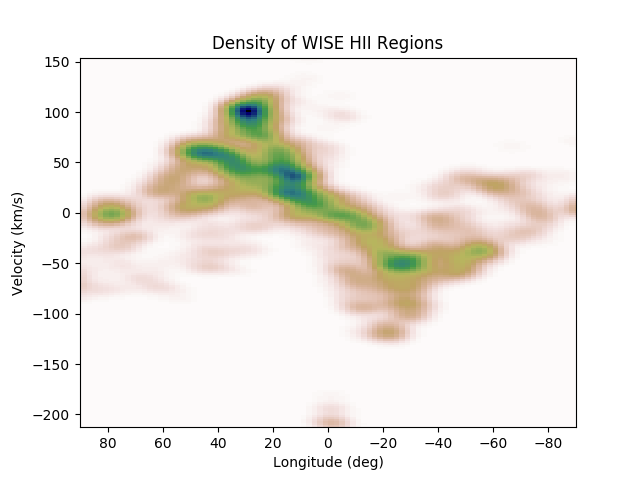

(90.0, -90.0)

In [14]:
# Do the same thing for the WISE data
xmin = wise_l.min()
xmax = wise_l.max()
ymin = wise_v.min()
ymax = wise_v.max()

X, Y = np.mgrid[xmin:xmax:180j, ymin:ymax:180j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([wise_l, wise_v])

kernel = stats.gaussian_kde(values,bw_method=bw2)
Z = np.reshape(kernel(positions).T, X.shape)

figure()
imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax],aspect='auto')
#plot(l1,v1,linestyle='None',marker='.',color='black')
#plot(l4,v4,linestyle='None',marker='.',color='black')

xlabel('Longitude (deg)')
ylabel('Velocity (km/s)')
title("Density of WISE HII Regions")
xlim(90.,-90.)



In [18]:
# Take the terminal velocity values and add a delta v
# See if the star formation tracers lie within dv 

v1min=v1-dv
v1max=v1+dv
v4min=v4-dv
v4max=v4+dv

# Initialise some arrays
lw_1=[]
bw_1=[]
vw_1=[]
lw_4=[]
bw_4=[]
vw_4=[]

# Check if the sources are in the right velocity range 
for i in range(len(wise_l)):
# First work for sources in the first quadrant
    if wise_l[i] >=l1.min() and wise_l[i]<=90.0:
        idx = (np.abs(l1-wise_l[i])).argmin()
        if (wise_v[i]>=v1min[idx] and wise_v[i]<=v1max[idx]): # Add it to the new list
            lw_1.append(wise_l[i])
            vw_1.append(wise_v[i])
            bw_1.append(wise_b[i])
# Now the fourth quadrant
    elif wise_l[i] >=l4.min() and wise_l[i]<=l4.max():
        idx = (np.abs(l4-wise_l[i])).argmin()
        if (wise_v[i]>=v4min[idx] and wise_v[i]<=v4max[idx]): # Add it to the new list
            lw_4.append(wise_l[i])
            vw_4.append(wise_v[i])
            bw_4.append(wise_b[i])



In [16]:
# Now see if the CO clouds lie within dv of the termminal velocity

# Initialise some arrays
lCO_1=[]
bCO_1=[]
vCO_1=[]
lCO_4=[]
bCO_4=[]
vCO_4=[]

# Check if the sources are in the right velocity range 
for i in range(len(lCO)):
# First work for sources in the first quadrant
    if lCO[i] >=l1.min() and lCO[i]<=90.0:
        idx = (np.abs(l1-lCO[i])).argmin()
        if (vCO[i]>=v1min[idx] and vCO[i]<=v1max[idx]): # Add it to the new list
            lCO_1.append(lCO[i])
            vCO_1.append(vCO[i])
            bCO_1.append(bCO[i])
# Now the fourth quadrant
    elif lCO[i] >=l4.min() and lCO[i]<=l4.max():
        idx = (np.abs(l4-lCO[i])).argmin()
        if (vCO[i]>=v4min[idx] and vCO[i]<=v4max[idx]): # Add it to the new list
            
            lCO_4.append(lCO[i])
            vCO_4.append(vCO[i])
            bCO_4.append(bCO[i])



In [19]:
# Now see if the HOPS clouds lie within dv of the termminal velocity

# Initialise some arrays
lHOPS_1=[]
bHOPS_1=[]
vHOPS_1=[]
lHOPS_4=[]
bHOPS_4=[]
vHOPS_4=[]

# Check if the sources are in the right velocity range 
for i in range(len(lHOPS)):
# First work for sources in the first quadrant
    if lHOPS[i] >=l1.min() and lHOPS[i]<=90.0:
        idx = (np.abs(l1-lHOPS[i])).argmin()
        if (vHOPS[i]>=v1min[idx] and vHOPS[i]<=v1max[idx]): # Add it to the new list
            lHOPS_1.append(lHOPS[i])
            vHOPS_1.append(vHOPS[i])
            bHOPS_1.append(bHOPS[i])
# Now the fourth quadrant
    elif lHOPS[i] >=l4.min() and lHOPS[i]<=l4.max():
        idx = (np.abs(l4-lHOPS[i])).argmin()
        if (vHOPS[i]>=v4min[idx] and vHOPS[i]<=v4max[idx]): # Add it to the new list
            
            lHOPS_4.append(lHOPS[i])
            vHOPS_4.append(vHOPS[i])
            bHOPS_4.append(bHOPS[i])



In [49]:
# Let's caclculate the KDE PDFs of the various star formation tracers to be used in the plots
# First the Q1 data
x1_grid =  np.linspace(l1.min(), l1.max(), 500)
# CO
kde = stats.gaussian_kde(lCO_1, bw_method=bw2)
#pdf_CO1=kde.evaluate(x1_grid)/max(kde.evaluate(x1_grid))
pdf_CO1=kde.evaluate(x1_grid)

# HII regions
kde = stats.gaussian_kde(lw_1, bw_method=bw2)
#pdf_W1=kde.evaluate(x1_grid)/max(kde.evaluate(x1_grid))
pdf_W1=kde.evaluate(x1_grid)

# HOPS NH3 regions
kde = stats.gaussian_kde(lHOPS_1, bw_method=bw2)
#pdf_HOPS1=kde.evaluate(x1_grid)/max(kde.evaluate(x1_grid))
pdf_HOPS1=kde.evaluate(x1_grid)




#Then the fourth quadrant
# CO
x4_grid =  np.linspace(l4.min(), l4.max(), 500)
kde = stats.gaussian_kde(lCO_4, bw_method=bw2)
#pdf_CO4=kde.evaluate(x4_grid)/max(kde.evaluate(x4_grid))
pdf_CO4=kde.evaluate(x4_grid)

# HII regions
kde = stats.gaussian_kde(lw_4, bw_method=bw2)
#pdf_W4=kde.evaluate(x4_grid)/max(kde.evaluate(x4_grid))
pdf_W4=kde.evaluate(x4_grid)

# HOPS NH3 regions
kde = stats.gaussian_kde(lHOPS_4, bw_method=bw2)
#pdf_HOPS4=kde.evaluate(x4_grid)/max(kde.evaluate(x4_grid))
pdf_HOPS4=kde.evaluate(x4_grid)








<IPython.core.display.Javascript object>


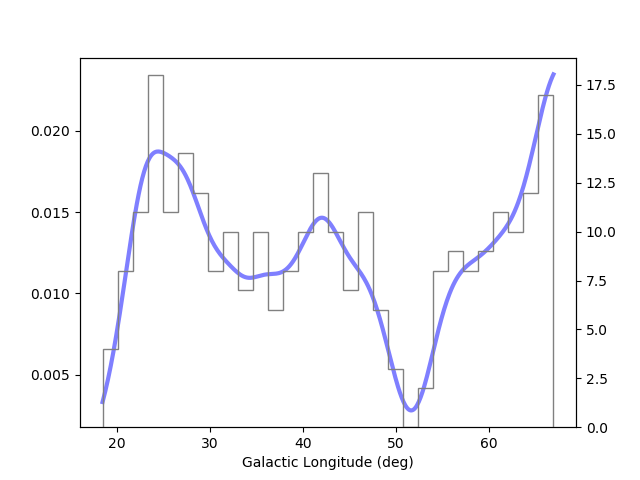

In [50]:
# Let's make a longitude KDE plot of these HII regions
# First the Q1 data
fig, ax1 = plt.subplots()
ax1.plot(x1_grid,pdf_CO1, color='blue', alpha=0.5, lw=3)   
xlabel('Galactic Longitude (deg)')
#title('Density of HII regions')
ax2=ax1.twinx()
n, bins, patches = ax2.hist(lCO_1, 30, range=(l1.min(),l1.max()),histtype='step',ec='gray', fc='gray')


<IPython.core.display.Javascript object>


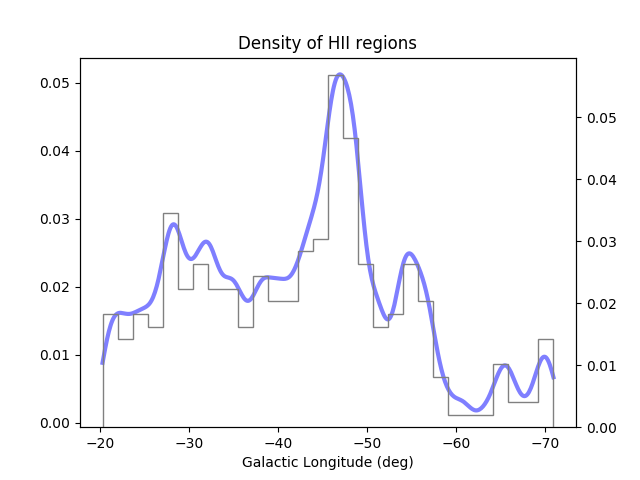

In [53]:
# Then the Q4 data
fig, ax1 = plt.subplots()
ax1.plot(x4_grid,pdf_CO4, color='blue', alpha=0.5, lw=3)  
xlim(-20.,-75.)
xlabel('Galactic Longitude (deg)')
title('Density of HII regions')
ax2=ax1.twinx()
n, bins, patches = ax2.hist(lCO_4, 30, range=(l4.min(),l4.max()),histtype='step',ec='gray', fc='gray',normed=True)


<IPython.core.display.Javascript object>


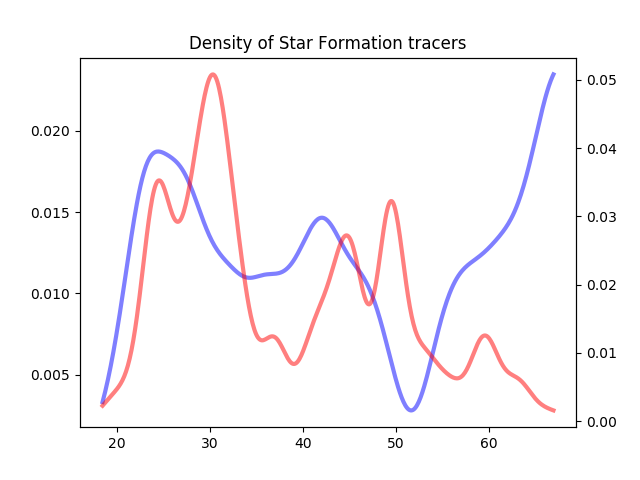

In [54]:
# Let's do the same plots for CO density
# Let's make a longitude KDE plot of these HII regions
# First the Q1 data
x_grid =  np.linspace(l1.min(), l1.max(), 500)
fig, ax1 = plt.subplots()
ax1.plot(x1_grid,pdf_CO1, color='blue', alpha=0.5, lw=3)   


# Overplot HII regions
ax2=ax1.twinx()
ax2.plot(x1_grid,pdf_W1, color='red', alpha=0.5, lw=3)  
xlabel('Galactic Longitude (deg)')
title('Density of Star Formation tracers')

#ax2=ax1.twinx()
#n, bins, patches = ax2.hist(lCO_1, 30, range=(l1.min(),l1.max()),histtype='step',ec='gray', fc='gray')



<IPython.core.display.Javascript object>


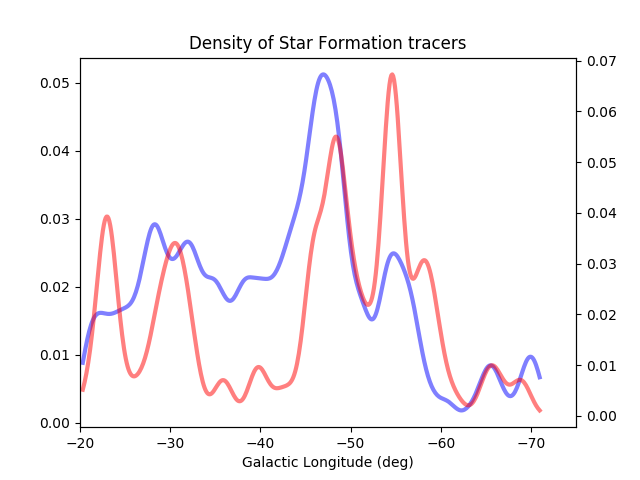

(-20.0, -75.0)

In [55]:
#Then the fourth quadrant
fig, ax1 = plt.subplots()
ax1.plot(x4_grid,pdf_CO4, color='blue', alpha=0.5, lw=3)   
xlabel('Galactic Longitude (deg)')
title('Density of Star Formation tracers')

# Overplot HII regions
ax2=ax1.twinx()
ax2.plot(x4_grid,pdf_W4, color='red', alpha=0.5, lw=3)  

xlim(-20.,-75.)
#n, bins, patches = ax2.hist(lCO_4, 30, range=(l4.min(),l4.max()),histtype='step',ec='gray', fc='gray')



### Load in the error function widths and plot those

In [56]:
def read_widths(filename):
    if  filename is None:
        raise ArgumentError("Please give a  filename")
    print "Opening file",filename
    data = np.loadtxt(filename)
    nrows,ncols=shape(data)
    npars=(ncols - 3)/2
    print "Npars:",npars," nrows:",nrows

# Prepare some arrays
    a=zeros((npars,nrows),float)
    err=zeros((npars,nrows),float)
    y=zeros(nrows,float)
    yerrvals=zeros(nrows,float)

# Fill the arrays with the parameters
    for i in range(0,npars):
        num=i+1
        j=i*2
        col="a"+str(num)
        print "Getting parameter",col
        a[i,:]=data[:,3+j]
        err[i,:]=data[:,4+j];
    l1=data[:,0]
    l2=data[:,1]
    long=(l1+l2)/2
    for i in range(0,nrows):
        if long[i]>=180.: 
            long[i]=long[i]-360.

        if npars>5:
            y[i]=a[0,i]+a[3,i]+a[5,i]
            yerrvals[i]=(err[0,i]**2+err[3,i]**2+err[5,i]**2)**0.5
        else:
            y[i]=a[0,i]+a[3,i]
            yerrvals[i]=(err[0,i]**2+err[3,i]**2)**0.5

    return a,err,long

In [57]:
# Read the first quadrant data and give some stats
fname = '/Users/naomi/Data/lv_modeling/kinematicsII/fitpars3comp.dat'
a1,err1,long1 = read_widths(fname)
print "\n"
print "Mean of comp-1: %.2f +/- %.2f" % (mean(a1[2,:]),std(a1[2,:]))
print "Mean of comp-2: %.2f +/- %.2f" % (mean(a1[4,:]), std(a1[4,:]))
print "Mean of comp-3: %.2f +/- %.2f" % (mean(a1[6,:]), std(a1[6,:]))

Opening file /Users/naomi/Data/lv_modeling/kinematicsII/fitpars3comp.dat
Npars: 7  nrows: 30
Getting parameter a1
Getting parameter a2
Getting parameter a3
Getting parameter a4
Getting parameter a5
Getting parameter a6
Getting parameter a7


Mean of comp-1: 6.89 +/- 1.65
Mean of comp-2: 13.79 +/- 2.86
Mean of comp-3: 33.83 +/- 6.47


<IPython.core.display.Javascript object>


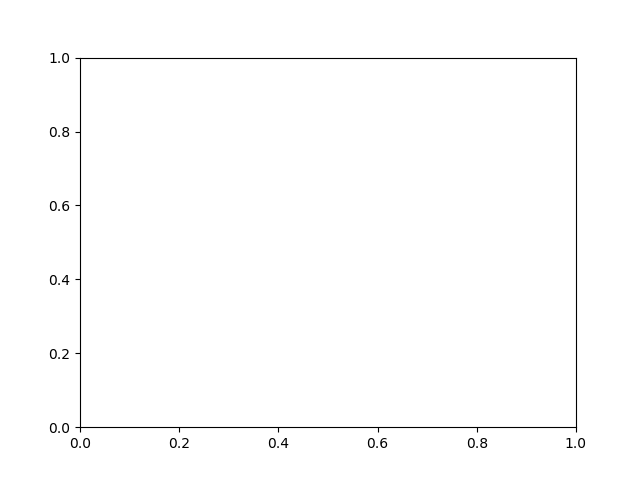

In [58]:
fig, ax = plt.subplots()

# Plot the widths with error bars
errorbar(long1,a1[2,:],yerr=err1[2,:],fmt="ko-",mfc="k")
errorbar(long1,a1[4,:],yerr=err1[4,:],fmt="k^-",mfc="k")
errorbar(long1,a1[6,:],yerr=err1[6,:],fmt="ks-",mfc="k")
xlabel(r"$l\ (deg)$") 
ylabel(r"$Fitted \,  velocity \, width \ (km\, s^{-1})$")


In [28]:
# Now read the fourth quadrant data and give some stats
fname = '/Users/naomi/Data/lv_modeling/4thquad_3comp.dat'
a4,err4,long4 = read_widths(fname)
print "\n"
print "Mean of comp-1: %.2f +/- %.2f" % (mean(a4[2,:]),std(a4[2,:]))
print "Mean of comp-2: %.2f +/- %.2f" % (mean(a4[4,:]), std(a4[4,:]))
print "Mean of comp-3: %.2f +/- %.2f" % (mean(a4[6,:]), std(a4[6,:]))

Opening file /Users/naomi/Data/lv_modeling/4thquad_3comp.dat
Npars: 7  nrows: 38
Getting parameter a1
Getting parameter a2
Getting parameter a3
Getting parameter a4
Getting parameter a5
Getting parameter a6
Getting parameter a7


Mean of comp-1: 6.46 +/- 2.07
Mean of comp-2: 12.78 +/- 3.22
Mean of comp-3: 25.54 +/- 7.92


<IPython.core.display.Javascript object>


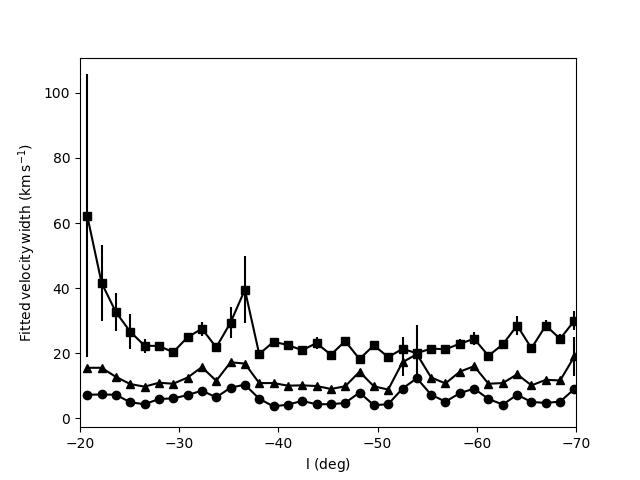

(-20.0, -70.0)

In [29]:
fig, ax = plt.subplots()

# Plot the widths with error bars
errorbar(long4,a4[2,:],yerr=err4[2,:],fmt="ko-",mfc="k")
errorbar(long4,a4[4,:],yerr=err4[4,:],fmt="k^-",mfc="k")
errorbar(long4,a4[6,:],yerr=err4[6,:],fmt="ks-",mfc="k")
xlabel(r"$l\ (deg)$") 
ylabel(r"$Fitted \,  velocity \, width \ (km\, s^{-1})$")
xlim(-20.,-70.)


<IPython.core.display.Javascript object>


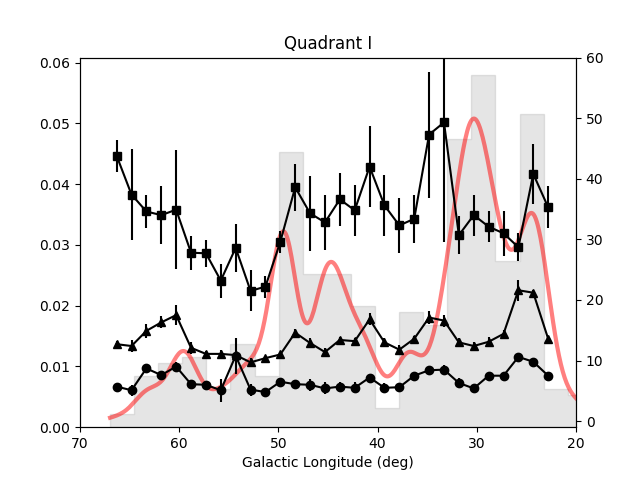

In [78]:
# Plot the HII regions, CO and the velocity widths for the first quadrant
fig, ax1 = plt.subplots()
#ax1.plot(x1_grid,pdf_CO1, color='blue', alpha=0.5, lw=3)   # CO
ax1.plot(x1_grid,pdf_W1, color='red', alpha=0.5, lw=3)     # WISE HII regions
#ax1.plot(x_grid,pdf_HOPS1, color='red', alpha=0.5, lw=3)   # HOPS
n, bins, patches =ax1.hist(lw_1, 20, range=(l1.min(),l1.max()),histtype='stepfilled',ec='gray', fc='gray',alpha=0.2,normed=True)

xlabel('Galactic Longitude (deg)')


ax2=ax1.twinx()
# Plot the widths with error bars
ax2.errorbar(long1,a1[2,:],yerr=err1[2,:],fmt="ko-",mfc="k")
ax2.errorbar(long1,a1[4,:],yerr=err1[4,:],fmt="k^-",mfc="k")
ax2. errorbar(long1,a1[6,:],yerr=err1[6,:],fmt="ks-",mfc="k")

title('Quadrant I')

ylim(-1,60)
xlim(70,20)

savefig('vels+HII_Q1.pdf')


<IPython.core.display.Javascript object>


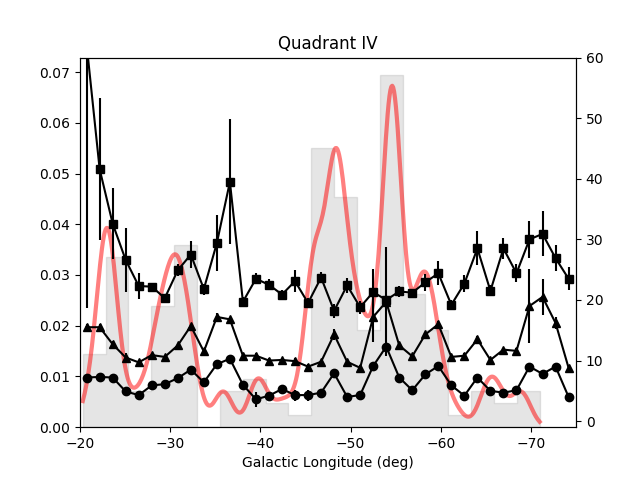

In [79]:
# Plot the HII regions, CO and the velocity widths for the fourth quadrant
fig, ax1 = plt.subplots()
#ax1.plot(x4_grid,pdf_CO4, color='blue', alpha=0.5, lw=3)   
# Overplot HII regions
ax1.plot(x4_grid,pdf_W4, color='red', alpha=0.5, lw=3)  
#ax1.plot(x4_grid,pdf_HOPS4, color='purple', alpha=0.5, lw=3)   # HOPS
n, bins, patches = ax1.hist(lw_4, 20, range=(l4.min(),l4.max()),histtype='stepfilled',ec='gray', fc='gray',alpha=0.2,normed=True)

xlabel('Galactic Longitude (deg)')




ax2=ax1.twinx()
ax2.errorbar(long4,a4[2,:],yerr=err4[2,:],fmt="ko-",mfc="k")
ax2.errorbar(long4,a4[4,:],yerr=err4[4,:],fmt="k^-",mfc="k")
ax2.errorbar(long4,a4[6,:],yerr=err4[6,:],fmt="ks-",mfc="k")

xlim(-20.,-75.)
ylim(-1,60)
#n, bins, patches = ax2.hist(lCO_4, 30, range=(l4.min(),l4.max()),histtype='step',ec='gray', fc='gray')
xlabel('Galactic Longitude (deg)')

title('Quadrant IV')
savefig('vels+HII_Q4.pdf')



<IPython.core.display.Javascript object>


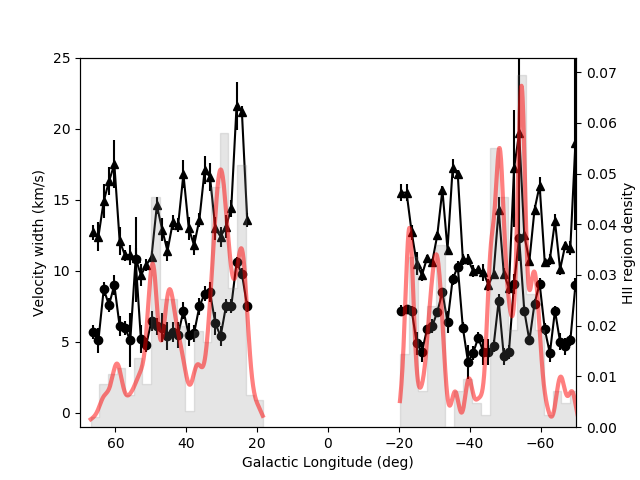

Type help() for interactive help, or help(object) for help about object.

In [107]:
# Make a plot of all together


fig, ax1 = plt.subplots()
# Plot the widths with error bars
ax1.errorbar(long1,a1[2,:],yerr=err1[2,:],fmt="ko-",mfc="k")
ax1.errorbar(long1,a1[4,:],yerr=err1[4,:],fmt="k^-",mfc="k")
#ax1. errorbar(long1,a1[6,:],yerr=err1[6,:],fmt="ks-",mfc="k")
# Now the fourth quadrant
ax1.errorbar(long4,a4[2,:],yerr=err4[2,:],fmt="ko-",mfc="k")
ax1.errorbar(long4,a4[4,:],yerr=err4[4,:],fmt="k^-",mfc="k")
#ax1.errorbar(long4,a4[6,:],yerr=err4[6,:],fmt="ks-",mfc="k")
xlabel('Galactic Longitude (deg)')
ylim(-1,25)
xlim(70.,-70)
ax1.set_ylabel('Velocity width (km/s)')


ax2=ax1.twinx()


#ax1.plot(x1_grid,pdf_CO1, color='blue', alpha=0.5, lw=3)   # CO
ax2.plot(x1_grid,pdf_W1, color='red', alpha=0.5, lw=3)     # WISE HII regions
#ax1.plot(x_grid,pdf_HOPS1, color='red', alpha=0.5, lw=3)   # HOPS
n, bins, patches =ax2.hist(lw_1, 20, range=(l1.min(),l1.max()),histtype='stepfilled',ec='gray', fc='gray',alpha=0.2,normed=True)
# Overplot HII regions
ax2.plot(x4_grid,pdf_W4, color='red', alpha=0.5, lw=3)  
#ax1.plot(x4_grid,pdf_HOPS4, color='purple', alpha=0.5, lw=3)   # HOPS
n, bins, patches = ax2.hist(lw_4, 20, range=(l4.min(),l4.max()),histtype='stepfilled',ec='gray', fc='gray',alpha=0.2,normed=True)


ax2.set_ylabel('HII region density')
xlim(70.,-70)
savefig("vels+HII_all.pdf")
help

In [108]:
8400*np.sin(np.radians(35.))

4818.0420653487872